In [1]:
from vae import *
import numpy as np
import matplotlib.pyplot as plt
import umap.umap_ as umap

/n/fs/ragr-research/users/yihangs/miniconda3/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
@torch.no_grad()
def generate_clustered_nb(
    n_clusters=4,
    points_per_cluster=300,
    n_features=60,
    latent_dim=2,          # keep at 2 for direct plotting
    theta_val=12.0,
    radius=3.0,
    cluster_spread=0.25,   # smaller => tighter clusters
    seed=123,
    device="cpu",
):
    """
    Build a clean clusterable dataset:
      z | c ~ N(center[c], cluster_spread^2 I) in R^2
      logits = z @ W^T + b
      px_scale = softmax(logits)
      mu = library * px_scale, library ~ LogNormal
      x ~ NB(mean=mu, total_count=theta_val)
    Returns: counts X [N,D], labels [N], true Z [N,2]
    """
    g = torch.Generator(device=device).manual_seed(seed)
    N = n_clusters * points_per_cluster

    # Arrange cluster centers on a circle
    centers = []
    for k in range(n_clusters):
        angle = 2 * math.pi * k / n_clusters
        centers.append([radius * math.cos(angle), radius * math.sin(angle)])
    centers = torch.tensor(centers, dtype=torch.float32, device=device)  # [K,2]

    # Sample cluster assignments
    labels = torch.arange(n_clusters, device=device).repeat_interleave(points_per_cluster)  # [N]
    # True latent z
    z = torch.randn(N, latent_dim, generator=g, device=device) * cluster_spread
    z += centers[labels]  # shift by cluster center -> tight, separated clusters

    # Decoder-ish linear map to gene space (fixed for data gen)
    W = torch.randn(n_features, latent_dim, generator=g, device=device) / math.sqrt(latent_dim)
    b = torch.randn(n_features, generator=g, device=device) * 0.2

    logits = z @ W.T + b                              # [N,D]
    px_scale = F.softmax(logits, dim=-1)              # proportions
    # Log-normal library sizes around ~5k counts
    lib = torch.exp(torch.randn(N, 1, generator=g, device=device) * 0.25 + 8.5)
    mu = lib * px_scale

    theta = torch.full_like(mu, float(theta_val))
    p = theta / (theta + mu + 1e-8)
    nb = NegativeBinomial(total_count=theta, probs=p)
    X = nb.sample()                                   # integer counts

    return X, labels.cpu(), z.cpu()

def plot_latents(true_z, enc_mu, labels, title_suffix=""):
    labels = labels.numpy()
    fig, axes = plt.subplots(1, 2 + int(USE_UMAP), figsize=(12 if USE_UMAP else 8, 4))

    # True latent
    ax = axes[0]
    sc = ax.scatter(true_z[:,0], true_z[:,1], c=labels, s=8, cmap="tab10")
    ax.set_title(f"Ground-truth latent{title_suffix}")
    ax.set_xlabel("z1"); ax.set_ylabel("z2")

    # Encoder mean
    ax = axes[1]
    sc = ax.scatter(enc_mu[:,0], enc_mu[:,1], c=labels, s=8, cmap="tab10")
    ax.set_title(f"Encoder μ (n_latent=2){title_suffix}")
    ax.set_xlabel("μ1"); ax.set_ylabel("μ2")

    if USE_UMAP:
        reducer = umap.UMAP(n_neighbors=20, min_dist=0.1, random_state=42)
        U = reducer.fit_transform(enc_mu)
        ax = axes[2]
        sc = ax.scatter(U[:,0], U[:,1], c=labels, s=8, cmap="tab10")
        ax.set_title(f"UMAP of encoder μ{title_suffix}")
        ax.set_xlabel("UMAP-1"); ax.set_ylabel("UMAP-2")

    plt.tight_layout()
    plt.show()

[001] loss=8213.195  kl_w=0.12
[005] loss=1547.466  kl_w=0.62
[010] loss=1041.444  kl_w=1.00
[015] loss=889.046  kl_w=1.00
[020] loss=560.827  kl_w=1.00
[025] loss=402.375  kl_w=1.00
[030] loss=337.642  kl_w=1.00
[035] loss=294.564  kl_w=1.00
[040] loss=271.401  kl_w=1.00
[045] loss=252.735  kl_w=1.00
[050] loss=254.150  kl_w=1.00
[055] loss=244.187  kl_w=1.00
[060] loss=238.008  kl_w=1.00
[065] loss=231.625  kl_w=1.00
[070] loss=236.039  kl_w=1.00
[075] loss=231.494  kl_w=1.00
[080] loss=227.650  kl_w=1.00
[085] loss=232.370  kl_w=1.00
[090] loss=230.033  kl_w=1.00
[095] loss=227.422  kl_w=1.00
[100] loss=223.145  kl_w=1.00
[105] loss=223.382  kl_w=1.00
[110] loss=223.402  kl_w=1.00
[115] loss=227.588  kl_w=1.00
[120] loss=221.433  kl_w=1.00
[125] loss=220.605  kl_w=1.00
[130] loss=220.422  kl_w=1.00
[135] loss=226.176  kl_w=1.00
[140] loss=221.030  kl_w=1.00
[145] loss=218.870  kl_w=1.00
[150] loss=232.126  kl_w=1.00
[155] loss=219.294  kl_w=1.00
[160] loss=220.059  kl_w=1.00
[165] l

/n/fs/ragr-research/users/yihangs/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/n/fs/ragr-research/users/yihangs/miniconda3/envs/py310/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


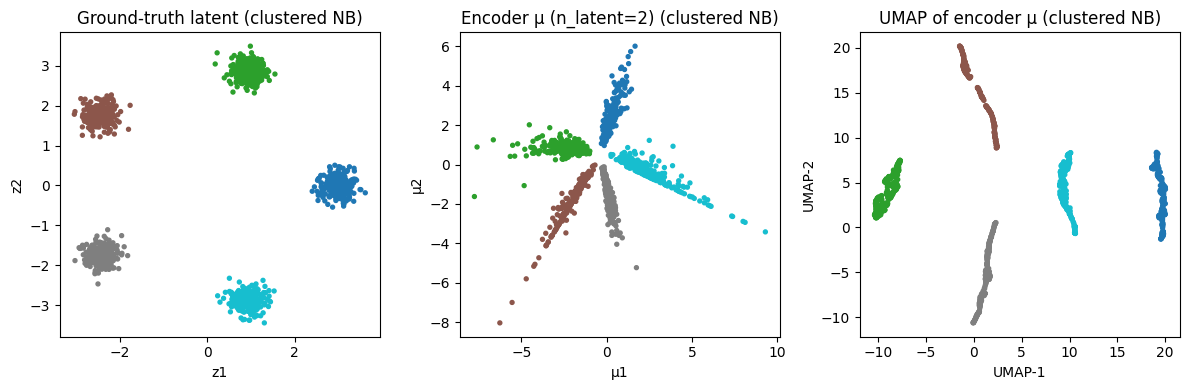

In [3]:
USE_UMAP = True
torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"

# ---- generate clearly separated clusters ----
X, y, Z_true = generate_clustered_nb(
    n_clusters=5, points_per_cluster=250, n_features=60,
    latent_dim=2, theta_val=12.0, radius=3.0, cluster_spread=0.20,
    seed=7, device=device
)

# ---- build and train VAE (n_latent=2) ----
model = VAE(n_input=X.shape[1], n_latent=2, n_hidden=128, n_layers=2).to(device)

dl = DataLoader(TensorDataset(X.float()), batch_size=128, shuffle=True)
# Gentle optimizer is important for stability
opt = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)

def fit_step(model, xb, kl_w):
    fwd = model(xb)
    losses = model.loss(xb, fwd, kl_weight=kl_w)
    return losses

model.train()
epochs, kl_warm = 200, 8
for ep in range(1, epochs+1):
    kl_w = min(1.0, ep / kl_warm)
    tot = 0.0; n = 0
    for (xb,) in dl:
        xb = xb.to(device).float()
        opt.zero_grad()
        losses = fit_step(model, xb, kl_w)
        losses["loss"].backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        opt.step()
        tot += losses["loss"].item() * xb.size(0)
        n += xb.size(0)
    if ep == 1 or ep % 5 == 0 or ep == epochs:
        print(f"[{ep:03d}] loss={tot/n:.3f}  kl_w={kl_w:.2f}")

# ---- encode the full dataset and visualize ----
model.eval()
with torch.no_grad():
    mu, _ = model._get_latent_params(X.float().to(device))
mu = mu.cpu().numpy()
plot_latents(Z_true.numpy(), mu, y, title_suffix=" (clustered NB)")